# Amazon Video Game Data Wrangling

Data from
> Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

In [59]:
# import packages
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline

# load English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load('en_core_web_sm')
import string
punctuations = string.punctuation
# Creating a Spacy Parser
from spacy.lang.en import English

In [2]:
vg = pd.read_json('../Amazon_Data/Video_Games_5.json.gz', lines=True, compression='gzip')

In [3]:
vg.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [4]:
vg = vg.loc[:,['overall', 'reviewText']]

## Notes
- 'asin' = product ID
- 'reviewText' = the review text
- 'overall' = the star rating

In [5]:
vg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 2 columns):
overall       497577 non-null int64
reviewText    497419 non-null object
dtypes: int64(1), object(1)
memory usage: 7.6+ MB


In [6]:
vg = vg.dropna(how='any')

In [7]:
vg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497419 entries, 0 to 497576
Data columns (total 2 columns):
overall       497419 non-null int64
reviewText    497419 non-null object
dtypes: int64(1), object(1)
memory usage: 11.4+ MB


In [8]:
# convert datatype to save memory
vg.loc[:, 'overall'] = vg.overall.astype('int16')

In [9]:
vg.shape

(497419, 2)

In [10]:
vg.overall.value_counts()

5    299623
4     93644
3     49140
1     30879
2     24133
Name: overall, dtype: int64

In [13]:
# split the data into features and target and train/test split
X = vg.reviewText.values
y = vg.overall.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=42, stratify=y)

In [14]:
# upsample the training data
train = pd.DataFrame({'overall': y_train, 'reviewText': X_train})

In [15]:
train.overall.value_counts()

5    224717
4     70233
3     36855
1     23159
2     18100
Name: overall, dtype: int64

In [16]:
# keep all of the indexes with a review of 5
# generate random samples of the other indexes to equal the value counts of 5
train5 = train[train.overall == 5]
train4_idxs = np.random.choice(train[train.overall == 4].index, 240000, replace=True)
train3_idxs = np.random.choice(train[train.overall == 3].index, 240000, replace=True)
train2_idxs = np.random.choice(train[train.overall == 2].index, 240000, replace=True)
train1_idxs = np.random.choice(train[train.overall == 1].index, 240000, replace=True)

In [17]:
train5.overall.value_counts()

5    224717
Name: overall, dtype: int64

In [18]:
# upsample the data
train = pd.concat([train5, train.iloc[train1_idxs,:], train.iloc[train2_idxs,:], 
                   train.iloc[train3_idxs,:], train.iloc[train4_idxs,:]])

In [19]:
train.overall.value_counts()

4    240000
3    240000
2    240000
1    240000
5    224717
Name: overall, dtype: int64

In [20]:
train.head()

,overall,reviewText
1,5,"Certainly not the best installment of the ""Ass..."
2,5,"My son loves this game, especially because its..."
3,5,One of the best consoles available!
4,5,the game works beautifully...graphics are stun...
6,5,Overview: If you like any of the GTA games yo...


In [21]:
train.shape

(1184717, 2)

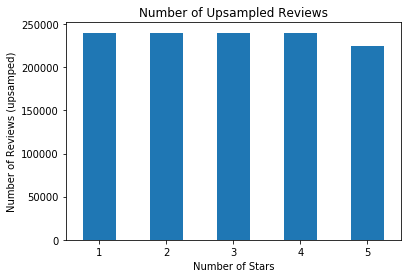

In [31]:
# display plot showing balanced data for training
_ = train.overall.value_counts().sort_index().plot(kind='bar')
_ = plt.title('Number of Upsampled Reviews')
_ = plt.xlabel('Number of Stars')
_ = plt.ylabel('Number of Reviews (upsamped)')
_ = plt.xticks(rotation=0)

In [32]:
# split training data into X, y
X_train = train.reviewText.values
y_train = train.overall.values

In [40]:
def clean_text(data):
    data = data.replace('\\n','')
    data = data.replace('\\','')
    return data

In [55]:
X_train[0].replace('\n', '').replace('\\','')

'Certainly not the best installment of the "Assassin\'s Creed" series, but all the talk of it being the absolute worst - I didn\'t see it.First there were complaints of it being full of glitches & bugs. I didn\'t really come across any in the many hours I played it. Game mechanics felt solid. I didn\'t experience any panicky button mashing moments trying to get an uncooperative character to do what I wanted. I was able to navigate the game world, which was so beautifully detailed as to make me feel as though I could smell the streets, quite nicely. I\'ll grant that I may have played "Unity" post patches so other experiences may vary. My only complaint about the artistic aspect of the game was that everyone in Paris, France seemed to have an English accent. (???)That said, a game that is considered bad due to glitches & bugs doesn\'t necessarily make it a "bad" game. The meat of any "Assassin\'s Creed" title is the story. "Unity\'s" story was adequate to move you through the game. The F

In [64]:
parser = English()
def my_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" 
                else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in punctuations]
    return mytokens

In [65]:
my_tokenizer(X_train[0])

['certainly',
 'not',
 'the',
 'well',
 'installment',
 'of',
 'the',
 'assassin',
 'have',
 'creed',
 'series',
 'but',
 'all',
 'the',
 'talk',
 'of',
 'it',
 'be',
 'the',
 'absolute',
 'wrong',
 'i',
 'do',
 'not',
 'see',
 'it',
 'first',
 'there',
 'be',
 'complaint',
 'of',
 'it',
 'be',
 'full',
 'of',
 'glitches',
 'bug',
 'i',
 'do',
 'not',
 'really',
 'come',
 'across',
 'any',
 'in',
 'the',
 'many',
 'hour',
 'i',
 'play',
 'it',
 'game',
 'mechanic',
 'feel',
 'solid',
 'i',
 'do',
 'not',
 'experience',
 'any',
 'panicky',
 'button',
 'mash',
 'moment',
 'try',
 'to',
 'get',
 'a',
 'uncooperative',
 'character',
 'to',
 'do',
 'what',
 'i',
 'want',
 'i',
 'be',
 'able',
 'to',
 'navigate',
 'the',
 'game',
 'world',
 'which',
 'be',
 'so',
 'beautifully',
 'detail',
 'a',
 'to',
 'make',
 'me',
 'feel',
 'a',
 'though',
 'i',
 'can',
 'smell',
 'the',
 'street',
 'quite',
 'nicely',
 'i',
 'will',
 'grant',
 'that',
 'i',
 'may',
 'have',
 'play',
 'unity',
 'post',
 